In [20]:
# Image Super-Resolution using an Efficient Sub-Pixel CNN

import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [21]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

In [22]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


In [23]:
# normalize images

def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

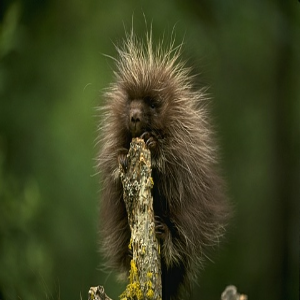

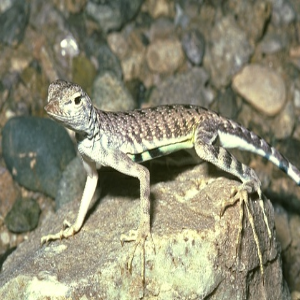

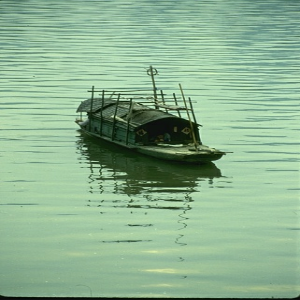

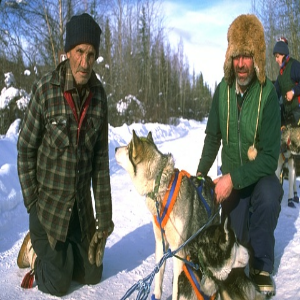

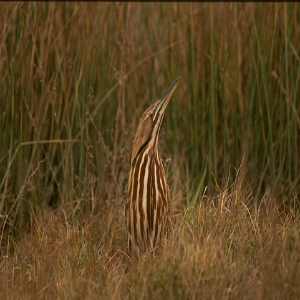

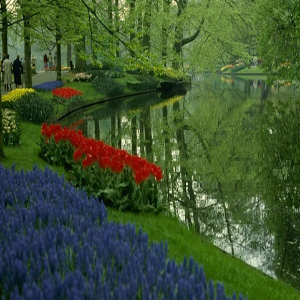

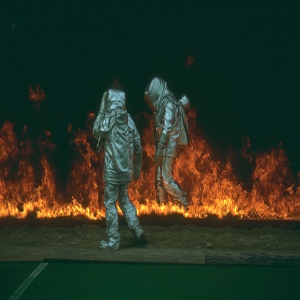

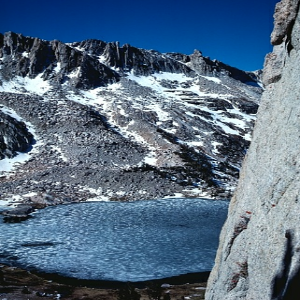

In [24]:
# Visualize samples

for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

In [25]:
# Prepare dataset of test images 
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

In [26]:
# Prepare images. Go from RGB to YUV
# Resize and crop

def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)
    

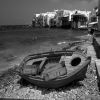

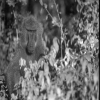

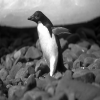

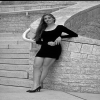

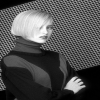

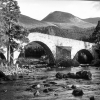

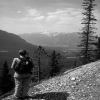

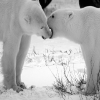

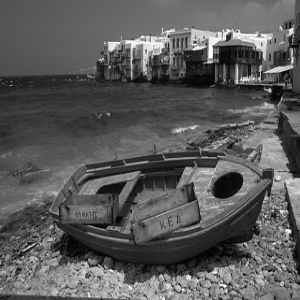

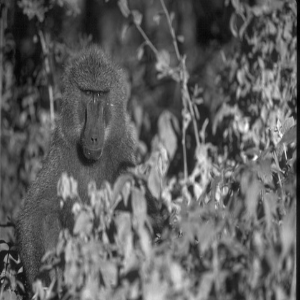

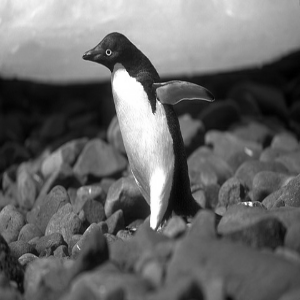

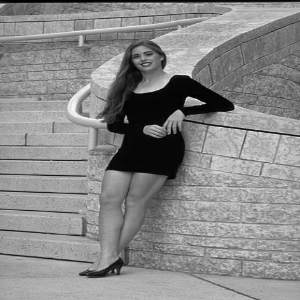

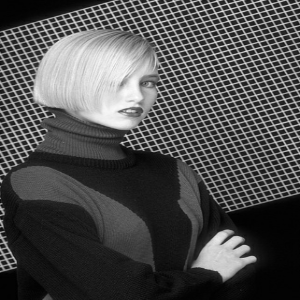

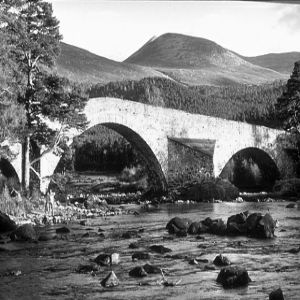

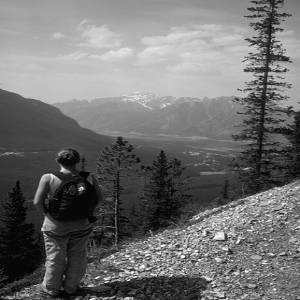

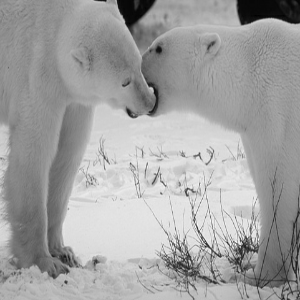

In [27]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [28]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(128, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [30]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [31]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "./tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, None, 64)    18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, None, 9)     1037

<PrefetchDataset shapes: ((None, 100, 100, 1), (None, 300, 300, 1)), types: (tf.float32, tf.float32)>
Epoch 1/50
50/50 - 2s - loss: 0.0208 - val_loss: 0.0051
Mean PSNR for epoch: 22.98


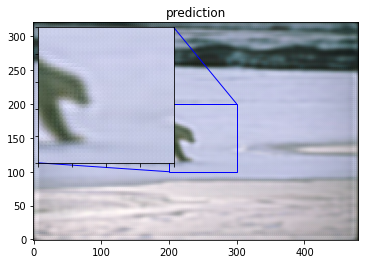

Epoch 2/50
50/50 - 1s - loss: 0.0045 - val_loss: 0.0045
Mean PSNR for epoch: 23.42
Epoch 3/50
50/50 - 1s - loss: 0.0036 - val_loss: 0.0029
Mean PSNR for epoch: 25.63
Epoch 4/50
50/50 - 1s - loss: 0.0030 - val_loss: 0.0026
Mean PSNR for epoch: 26.42
Epoch 5/50
50/50 - 1s - loss: 0.0029 - val_loss: 0.0025
Mean PSNR for epoch: 26.15
Epoch 6/50
50/50 - 1s - loss: 0.0028 - val_loss: 0.0024
Mean PSNR for epoch: 26.38
Epoch 7/50
50/50 - 1s - loss: 0.0029 - val_loss: 0.0025
Mean PSNR for epoch: 26.15
Epoch 8/50
50/50 - 1s - loss: 0.0028 - val_loss: 0.0024
Mean PSNR for epoch: 26.28
Epoch 9/50
50/50 - 1s - loss: 0.0027 - val_loss: 0.0026
Mean PSNR for epoch: 26.06
Epoch 10/50
50/50 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.37
Epoch 11/50
50/50 - 1s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.39
Epoch 12/50
50/50 - 1s - loss: 0.0031 - val_loss: 0.0028
Mean PSNR for epoch: 25.45
Epoch 13/50
50/50 - 1s - loss: 0.0027 - val_loss: 0.0023
Mean PSNR for epoch: 26.43


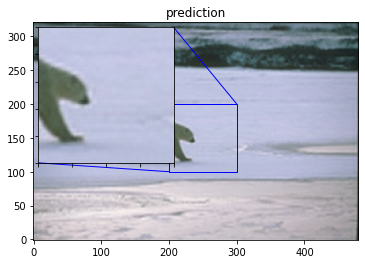

Epoch 22/50
50/50 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.17
Epoch 23/50
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.62
Epoch 24/50
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.72
Epoch 25/50
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 27.07
Epoch 26/50
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.36
Epoch 27/50
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 27.25
Epoch 28/50
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.59
Epoch 29/50
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.69
Epoch 30/50
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.51
Epoch 31/50
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.20
Epoch 32/50
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.58
Epoch 33/50
50/50 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch

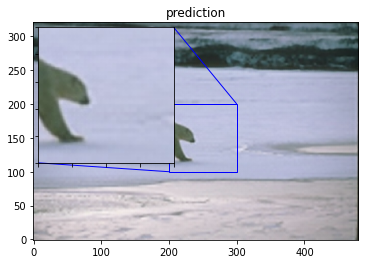

Epoch 42/50
50/50 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.76
Epoch 43/50
50/50 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.92
Epoch 44/50
50/50 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.94
Epoch 45/50
50/50 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.54
Epoch 46/50
50/50 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.26
Epoch 47/50
50/50 - 1s - loss: 0.0028 - val_loss: 0.0045
Mean PSNR for epoch: 23.67
Epoch 48/50
50/50 - 1s - loss: 0.0032 - val_loss: 0.0023
Mean PSNR for epoch: 26.28
Epoch 49/50
50/50 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.59
Epoch 50/50
50/50 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.49


In [32]:
epochs = 50
print(train_ds)
model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

PSNR of low resolution image and high resolution image is 28.6357
PSNR of predict and high resolution is 29.7018


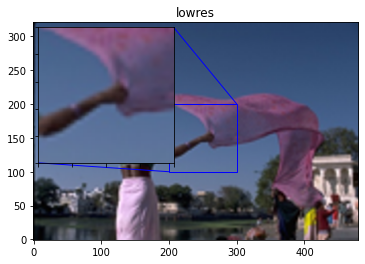

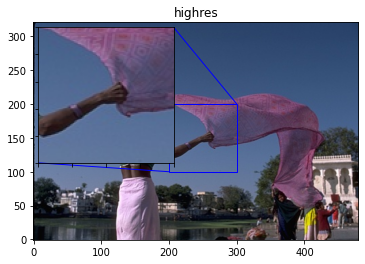

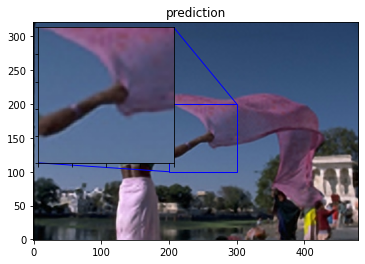

PSNR of low resolution image and high resolution image is 28.4498
PSNR of predict and high resolution is 28.8933


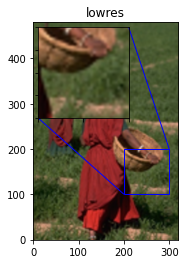

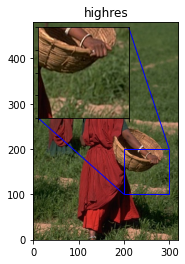

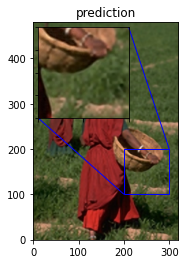

PSNR of low resolution image and high resolution image is 28.2105
PSNR of predict and high resolution is 29.6696


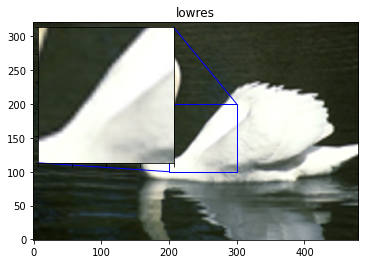

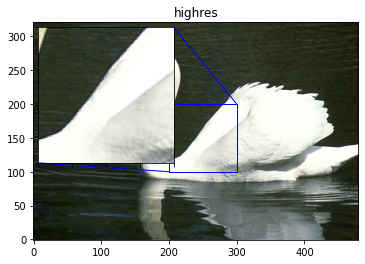

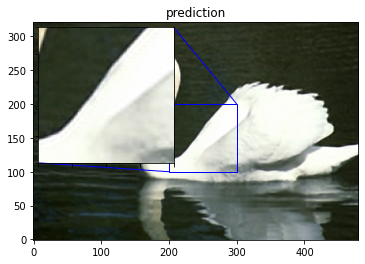

PSNR of low resolution image and high resolution image is 26.9877
PSNR of predict and high resolution is 27.5072


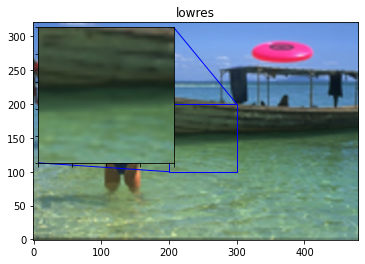

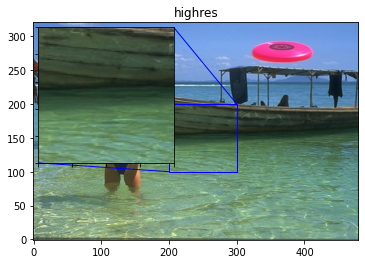

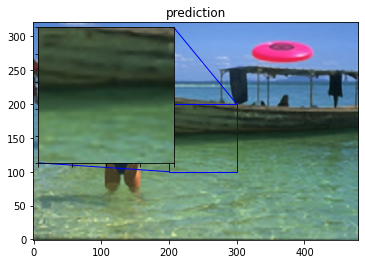

PSNR of low resolution image and high resolution image is 24.2759
PSNR of predict and high resolution is 25.3240


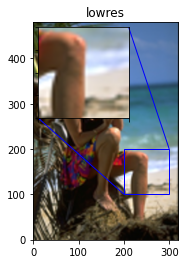

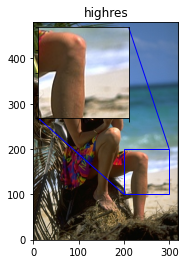

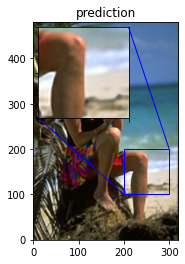

PSNR of low resolution image and high resolution image is 28.2925
PSNR of predict and high resolution is 28.9828


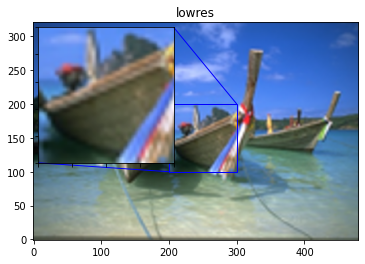

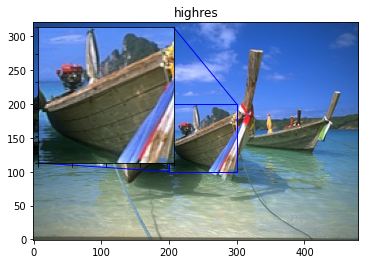

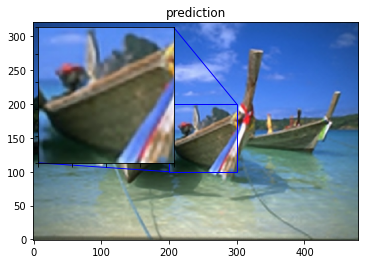

PSNR of low resolution image and high resolution image is 24.7785
PSNR of predict and high resolution is 25.1742


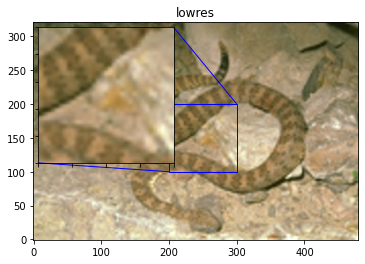

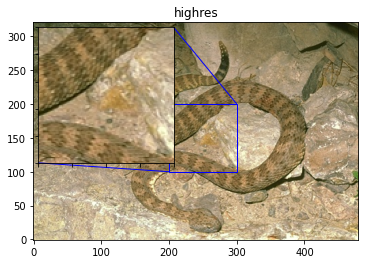

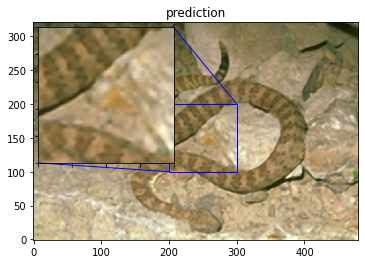

PSNR of low resolution image and high resolution image is 24.0189
PSNR of predict and high resolution is 24.6696


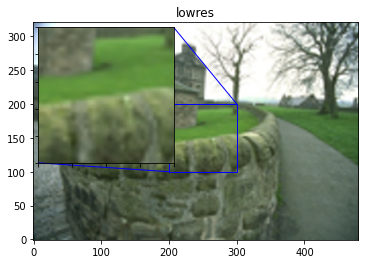

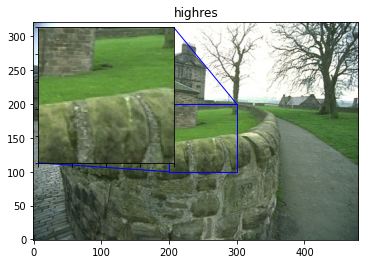

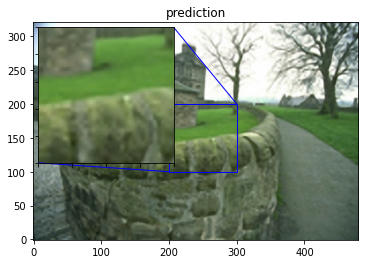

PSNR of low resolution image and high resolution image is 26.6041
PSNR of predict and high resolution is 27.0123


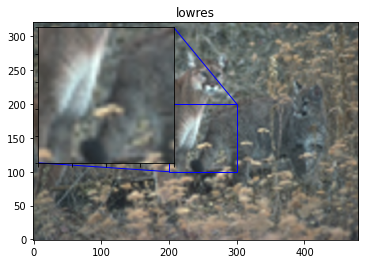

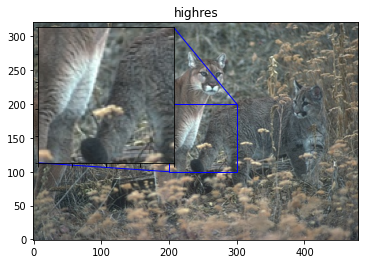

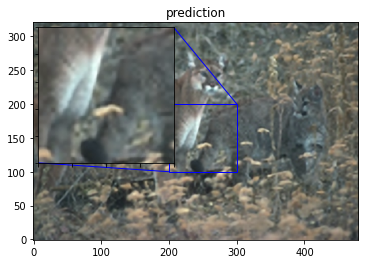

PSNR of low resolution image and high resolution image is 20.8932
PSNR of predict and high resolution is 21.2315


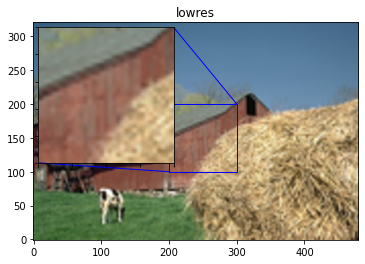

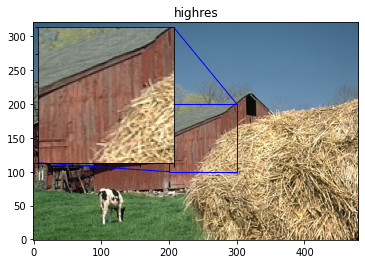

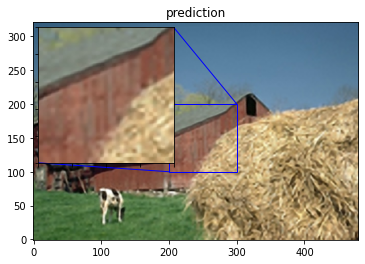

Avg. PSNR of lowres images is 26.1147
Avg. PSNR of reconstructions is 26.8166


In [19]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[190:200]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))